<a href="https://colab.research.google.com/github/ahatasham5/Breast_Cancer_Prognosis/blob/main/test_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


In [4]:
%cd /content/drive/MyDrive/Dataset/

/content/drive/MyDrive/Dataset


In [5]:
ls

'Biglycan breast cancer dataset'/   model_checkpoint.pth       model_weights.pth
 checkpoint.pth                     model_checkpoint_vgg.pth


In [6]:
# Define your dataset directory
dataset_dir = "Biglycan breast cancer dataset"

In [7]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(dataset_dir, transform=transform)

# Split into train and validation sets (80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)  # Apply the third max pooling

        x = self.flatten(x)  # Flatten the output

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)  # Output of the final fully connected layer
        return x

In [15]:
model = SimpleCNN()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # You can try different optimizers and learning rates

In [18]:
num_epochs = 100  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# After training for some epochs
torch.save(model.state_dict(), 'model_weights_base.pth')

Epoch 1, Loss: 1.2428968879911635
Epoch 2, Loss: 0.6977316472265456
Epoch 3, Loss: 0.68204755253262
Epoch 4, Loss: 0.6528486477004157
Epoch 5, Loss: 0.6795180506176419
Epoch 6, Loss: 0.6457771327760484
Epoch 7, Loss: 0.6705374519030253
Epoch 8, Loss: 0.6763460040092468
Epoch 9, Loss: 0.6966735323270162
Epoch 10, Loss: 0.6423914035161337
Epoch 11, Loss: 0.6555303666326735
Epoch 12, Loss: 0.6638561288515726
Epoch 13, Loss: 0.644227061006758
Epoch 14, Loss: 0.6512995494736565
Epoch 15, Loss: 0.6470589836438497
Epoch 16, Loss: 0.6407503883043925
Epoch 17, Loss: 0.6327785054842631
Epoch 18, Loss: 0.6363672349188063
Epoch 19, Loss: 0.595253500673506
Epoch 20, Loss: 0.5931703646977743
Epoch 21, Loss: 0.598042799366845
Epoch 22, Loss: 0.49049653278456795
Epoch 23, Loss: 0.4067525267601013
Epoch 24, Loss: 0.6404358314143287
Epoch 25, Loss: 1.1282894015312195
Epoch 26, Loss: 0.6503024763531156
Epoch 27, Loss: 0.686647031042311
Epoch 28, Loss: 0.660409324698978
Epoch 29, Loss: 0.6621047721968757


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [40]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
all_preds = []
all_targets = []
all_probs = []  # Collect all probabilities

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Apply sigmoid since we used BCEWithLogitsLoss
        predicted_probs = torch.sigmoid(outputs)

        # Convert probabilities to predicted class (0 or 1)
        predicted = predicted_probs > 0.5

        # Move tensors to CPU before converting to NumPy
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        all_probs.extend(predicted_probs.cpu().numpy().flatten())  # Flatten the probabilities

Confusion Matrix:
[[36  4]
 [25  3]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.59      0.90      0.71        40
   Cancerous       0.43      0.11      0.17        28

    accuracy                           0.57        68
   macro avg       0.51      0.50      0.44        68
weighted avg       0.52      0.57      0.49        68

Accuracy: 57.35%
Precision: 42.86%
Recall: 10.71%
F1 Score: 17.14%
AUC: 0.69


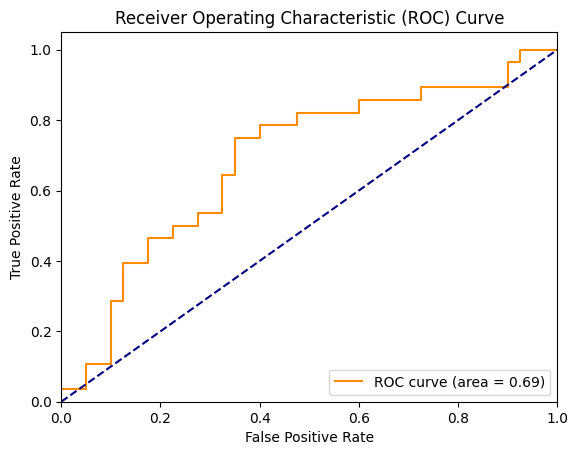

In [45]:
# Calculate and print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(all_targets, np.array(all_preds)))

print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds), target_names=['Healthy', 'Cancerous']))

accuracy = accuracy_score(all_targets, all_preds) # Remove the loop for accuracy
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# AUC calculation
auc_value = roc_auc_score(all_targets, np.array(all_probs))
print(f"AUC: {auc_value:.2f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)  # Use all_probs directly
roc_auc = roc_auc_score(all_targets, np.array(all_probs)) # Calculate the area under the curve


plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()